In [1]:
import os
# import annoy
import re
import json
import requests
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from typing import List, Tuple

from generator import *
from visualization import *

In [2]:
tmp = {'id' : [], 'type' : []}
with open('C:/KU/ai-stylist/ai-stylist/data/polyvore_outfits/polyvore_item_metadata.json', 'r') as f:
    txt = json.load(f)
    for id, metadata in txt.items():
        tmp['id'].append(id)
        tmp['type'].append(metadata["semantic_category"])
df = pd.DataFrame.from_dict(tmp)
df = df.set_index('id')

In [4]:
generator = FashionEmbeddingGenerator()
generator.to(device='cuda')

def img_folder2embeds(data_path, batch_size: int=512):
    tmp = {'id': [], 'embed': []}
    file_paths = os.listdir(data_path)

    for idx in tqdm(range(0, len(file_paths), batch_size)):
        batch = file_paths[idx:idx + batch_size]
        ids = list(map(lambda x: re.sub(r'\.jpg$', '', x), batch))
        images = list(map(lambda x: Image.open(os.path.join(data_path, x)), batch))
        embeds = generator.img2embed(images)

        tmp['id'] += ids
        tmp['embed'] += embeds

    embed_df = pd.DataFrame.from_dict(tmp)
    embed_df = df.set_index('id')
    return embed_df

In [14]:
data_path = 'c:/KU/ai-stylist/ai-stylist/data/polyvore_outfits/images'
embed_df = img_folder2embeds(data_path)

  0%|          | 0/510 [00:08<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
df = df.merge(embed_df, how='outer', on='left')

In [8]:
df = pd.read_json('../data/polyvore_cleaned/bottom_embeds.json')

In [13]:
query_idx = 512
query = df.iloc[query_idx]
df['sim'] = df.apply(lambda x: torch.nn.CosineSimilarity(dim=0)(torch.Tensor(x['embed']), torch.Tensor(query['embed'])), axis=1)

n=10

print('query')
query_file_name = str(query['id']) + '.jpg'
show_single_image(data_path, query_file_name)

print('most_similar G.T')
most_similar = df.sort_values('sim', ascending=False, ignore_index=True)[1:n + 1]
file_names = list(map(lambda x: str(x) + '.jpg', most_similar['id'].tolist()))
show_top_n_image(data_path, file_names, most_similar['sim'].tolist(), n=n)

print('least_similar G.T')
least_similar = df.sort_values('sim', ascending=True, ignore_index=True)[0:n]
file_names = list(map(lambda x: str(x) + '.jpg', least_similar['id'].tolist()))
show_top_n_image(data_path, file_names, least_similar['sim'].tolist(), n=n)

query


NameError: name 'data_path' is not defined

In [11]:
df["id"] = df.index

In [12]:
df

,embed,sim,id
100019428,"[0.6310518384, -1.8156820536, 0.2668655217, 0....",tensor(0.5021),100019428
100055005,"[0.0692711174, -1.4091836214, 0.77789938450000...",tensor(0.6256),100055005
100058774,"[-0.0355502367, -0.20539242030000002, 0.367238...",tensor(0.5520),100058774
100059723,"[-0.1544801891, -1.288596034, 0.2367265671, 0....",tensor(0.4938),100059723
100063042,"[-0.2909300923, -0.36167433860000003, 0.837074...",tensor(0.6616),100063042
...,...,...,...
99962760,"[0.0202621669, 0.26750537750000003, -0.1376728...",tensor(0.5070),99962760
99962842,"[-0.3177760243, 0.675921917, 0.7182554007, -0....",tensor(0.4933),99962842
99965006,"[0.048725049900000005, -0.5925166607, 0.564946...",tensor(0.7101),99965006
99969800,"[0.1959436983, -0.2706330717, 0.64573645590000...",tensor(0.7474),99969800


Query : a photo of casual and daily style clothes
Most similar


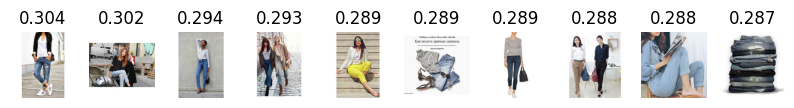

Least similar


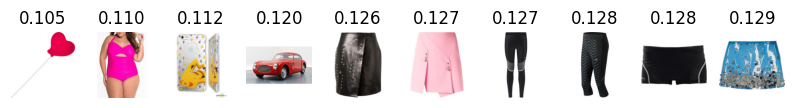

In [33]:
query_txt = "a photo of casual and daily style clothes"
query_embed = generator.text2embed(query_txt)[0]

df['sim'] = df.apply(lambda x: torch.nn.CosineSimilarity(dim=0)(torch.Tensor(x['embed']), torch.Tensor(query_embed)), axis=1)

n=10

print('Query : ' + query_txt)

print('Most similar')
most_similar = df.sort_values('sim', ascending=False, ignore_index=True)[1:n + 1]
file_names = list(map(lambda x: str(x) + '.jpg', most_similar['id'].tolist()))
show_top_n_image(data_path, file_names, most_similar['sim'].tolist(), n=n)

print('Least similar')
least_similar = df.sort_values('sim', ascending=True, ignore_index=True)[0:n]
file_names = list(map(lambda x: str(x) + '.jpg', least_similar['id'].tolist()))
show_top_n_image(data_path, file_names, least_similar['sim'].tolist(), n=n)



In [32]:
styles = ["formal and minimal",
          "athletic and sports",
          "casual and daily", 
          "ethnic, hippie, and maximalism", 
          "hip-hop and street", 
          "preppy and classic", 
          "feminine and girlish"]

threshold = 0.2

for s in styles:
    query_txt = f"a photo of {s} style clothes"
    query_embed = generator.text2embed(query_txt)[0]

    df['sim'] = df.apply(lambda x: torch.nn.CosineSimilarity(dim=0)(torch.Tensor(x['embed']), torch.Tensor(query_embed)), axis=1)
    
    
    ratio = len(df.loc[df["sim"] >= threshold])/len(df)*100
    print(f"{ratio}% of garments for {s}")


41.611853993494755% of garments for formal and minimal
41.109504878930245% of garments for athletic and sports
40.25298156848572% of garments for casual and daily
13.498373689916878% of garments for ethnic, hippie, and maximalism
20.220455366823277% of garments for hip-hop and street
31.04083845319841% of garments for preppy and classic
62.3310444524756% of garments for feminine and girlish


In [ ]:
# Annoy Initialization
annoy_index = annoy.AnnoyIndex(f=512, metric='angular') # 512 is embed size of CLIP

for i, row in df.iterrows():
    annoy_index.add_item(i, np.array(row['embed']))

annoy_index.build(n_trees=10) # More n_tree helps improve accuracy
annoy_index.save('test.ann')

In [ ]:
# Embedding Vector of Query
query_embed = np.array(query['embed'])
# It outputs 'index' and 'distance' (the smaller, the more similar) for n similar vectors.
get_nns_list = annoy_index.get_nns_by_vector(vector=query_embed, n=n, include_distances=True)

print('most_similar ANN')
file_names = list(map(lambda x: str(df.iloc[x]['id']) + '.jpg', get_nns_list[0]))
show_top_n_image(data_path, file_names, get_nns_list[1], n=n)